# Restaurant Revenue Prediction
Models used:
* Lasso & Ridge Regression
* ElasticNet
* KNN Regressor
* Random Forest
* Light GBM
* XGBoost
* Ensembling

In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from scipy import stats
from scipy.stats import norm, skew
from sklearn import preprocessing
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/restaurant-revenue-prediction/train.csv.zip
/kaggle/input/restaurant-revenue-prediction/test.csv.zip
/kaggle/input/restaurant-revenue-prediction/sampleSubmission.csv


In [2]:
df = pd.read_csv('/kaggle/input/restaurant-revenue-prediction/train.csv.zip')
df.shape

(137, 43)

The dataset is quite small so complex models with many parameters should be avoided. Using a complex model for this dataset will cause the model to overfit to the dataset. Regularization techniques will definitely need to be used to prevent the possibility of overfitting.

In [3]:
test_df = pd.read_csv('/kaggle/input/restaurant-revenue-prediction/test.csv.zip')
test_df.shape

(100000, 42)

In [4]:
df.head()

,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,...,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
0,0,07/17/1999,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,...,3.0,5,3,4,5,5,4,3,4,5653753.0
1,1,02/14/2008,Ankara,Big Cities,FC,4,5.0,4.0,4.0,1,...,3.0,0,0,0,0,0,0,0,0,6923131.0
2,2,03/09/2013,Diyarbakır,Other,IL,2,4.0,2.0,5.0,2,...,3.0,0,0,0,0,0,0,0,0,2055379.0
3,3,02/02/2012,Tokat,Other,IL,6,4.5,6.0,6.0,4,...,7.5,25,12,10,6,18,12,12,6,2675511.0
4,4,05/09/2009,Gaziantep,Other,IL,3,4.0,3.0,4.0,2,...,3.0,5,1,3,2,3,4,3,3,4316715.0


In [5]:
df.describe()

,Id,P1,P2,P3,P4,P5,P6,P7,P8,P9,...,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
count,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,...,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,1.370000e+02
mean,68.000000,4.014599,4.408759,4.317518,4.372263,2.007299,3.357664,5.423358,5.153285,5.445255,...,3.135036,2.729927,1.941606,2.525547,1.138686,2.489051,2.029197,2.211679,1.116788,4.453533e+06
std,39.692569,2.910391,1.514900,1.032337,1.016462,1.209620,2.134235,2.296809,1.858567,1.834793,...,1.680887,5.536647,3.512093,5.230117,1.698540,5.165093,3.436272,4.168211,1.790768,2.576072e+06
min,0.000000,1.000000,1.000000,0.000000,3.000000,1.000000,1.000000,1.000000,1.000000,4.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.149870e+06
25%,34.000000,2.000000,4.000000,4.000000,4.000000,1.000000,2.000000,5.000000,4.000000,4.000000,...,2.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.999068e+06
50%,68.000000,3.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,5.000000,5.000000,...,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.939804e+06
75%,102.000000,4.000000,5.000000,5.000000,5.000000,2.000000,4.000000,5.000000,5.000000,5.000000,...,3.000000,4.000000,3.000000,3.000000,2.000000,3.000000,4.000000,3.000000,2.000000,5.166635e+06
max,136.000000,12.000000,7.500000,7.500000,7.500000,8.000000,10.000000,10.000000,10.000000,10.000000,...,7.500000,25.000000,15.000000,25.000000,6.000000,24.000000,15.000000,20.000000,8.000000,1.969694e+07


In [6]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

display_all(df.head().transpose())

,0,1,2,3,4
Id,0,1,2,3,4
Open Date,07/17/1999,02/14/2008,03/09/2013,02/02/2012,05/09/2009
City,İstanbul,Ankara,Diyarbakır,Tokat,Gaziantep
City Group,Big Cities,Big Cities,Other,Other,Other
Type,IL,FC,IL,IL,IL
P1,4,4,2,6,3
P2,5,5,4,4.5,4
P3,4,4,2,6,3
P4,4,4,5,6,4
P5,2,1,2,4,2


In [7]:
df.isnull().sum().sort_index()/len(df)

City          0.0
City Group    0.0
Id            0.0
Open Date     0.0
P1            0.0
P10           0.0
P11           0.0
P12           0.0
P13           0.0
P14           0.0
P15           0.0
P16           0.0
P17           0.0
P18           0.0
P19           0.0
P2            0.0
P20           0.0
P21           0.0
P22           0.0
P23           0.0
P24           0.0
P25           0.0
P26           0.0
P27           0.0
P28           0.0
P29           0.0
P3            0.0
P30           0.0
P31           0.0
P32           0.0
P33           0.0
P34           0.0
P35           0.0
P36           0.0
P37           0.0
P4            0.0
P5            0.0
P6            0.0
P7            0.0
P8            0.0
P9            0.0
Type          0.0
revenue       0.0
dtype: float64

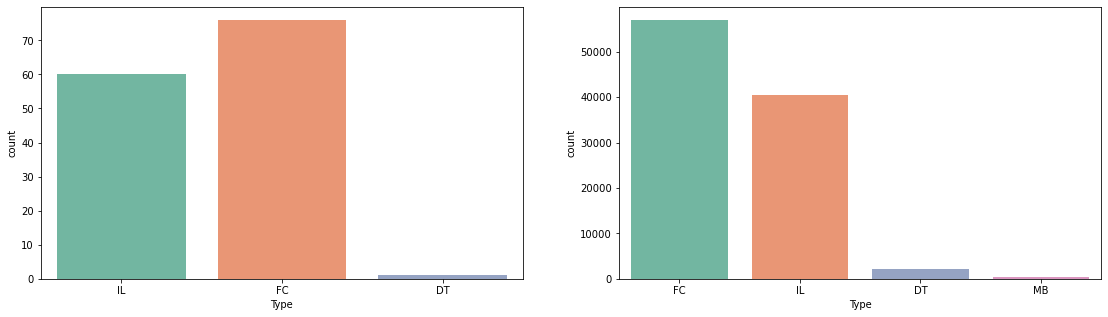

In [8]:
fig, ax = plt.subplots(1,2, figsize=(19, 5))
g1 = sns.countplot(df['Type'],palette="Set2", ax=ax[0]);
g2 = sns.countplot(test_df['Type'],palette="Set2", ax=ax[1]);
fig.show()

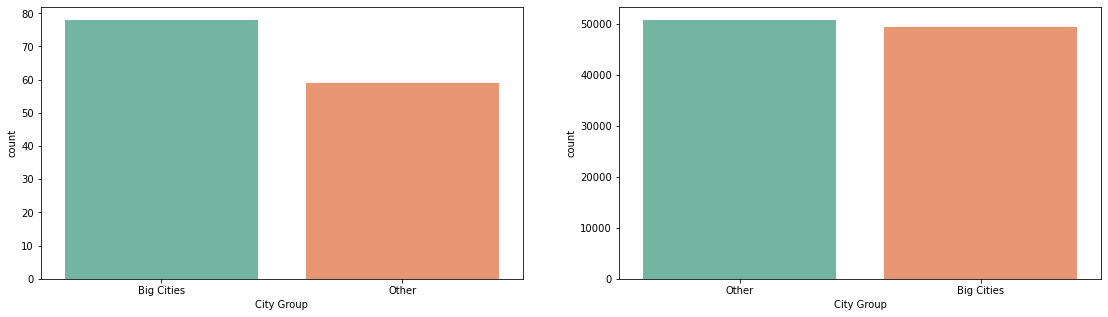

In [9]:
fig, ax = plt.subplots(1,2, figsize=(19, 5))
g1 = sns.countplot(df['City Group'],palette="Set2", ax=ax[0]);
g2 = sns.countplot(test_df['City Group'],palette="Set2", ax=ax[1]);
fig.show()

In [10]:
(df['City'].nunique(), test_df['City'].nunique())

(34, 57)

The **MB** Type will be replaced with the **DT** Type in the test set since it's not available in our training set. The **City** feature is useless since our training set contains **34** unique cities but the test set contains **57** unique cities.

In [11]:
test_df.loc[test_df['Type']=='MB', 'Type'] = 'DT'

In [12]:
df.drop('City', axis=1, inplace=True)
test_df.drop('City', axis=1, inplace=True)

In [13]:
import datetime
df.drop('Id',axis=1,inplace=True)
df['Open Date']  = pd.to_datetime(df['Open Date'])
test_df['Open Date']  = pd.to_datetime(test_df['Open Date'])
launch_date = datetime.datetime(2015, 3, 23)
# scale days open
df['Days Open'] = (launch_date - df['Open Date']).dt.days / 1000
test_df['Days Open'] = (launch_date - test_df['Open Date']).dt.days / 1000
df.drop('Open Date', axis=1, inplace=True)
test_df.drop('Open Date', axis=1, inplace=True)

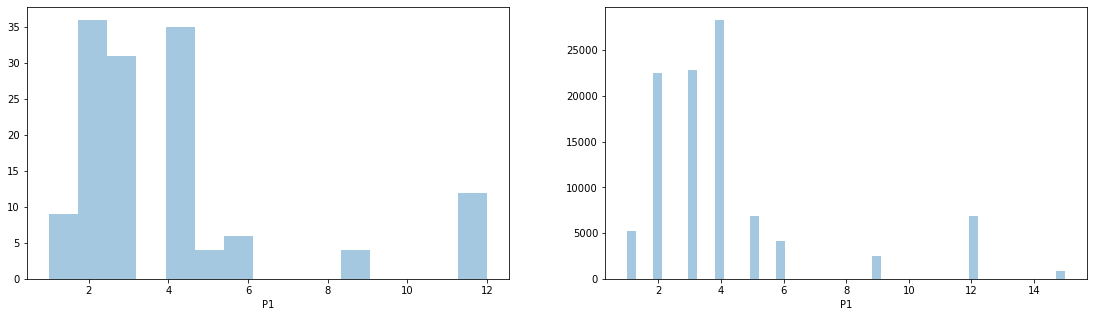

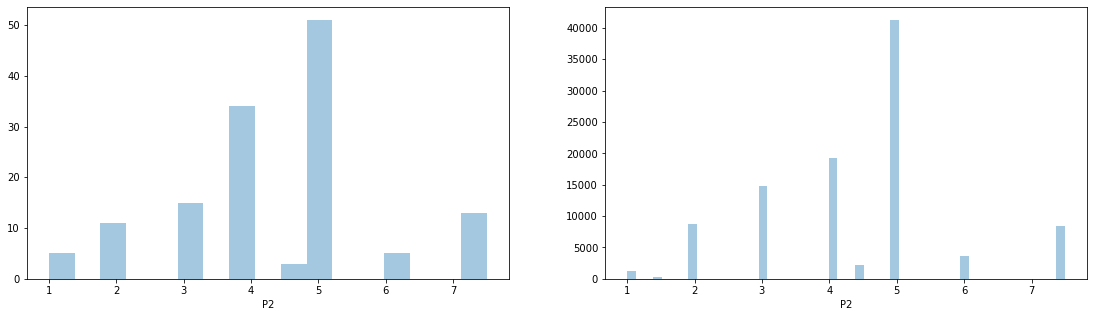

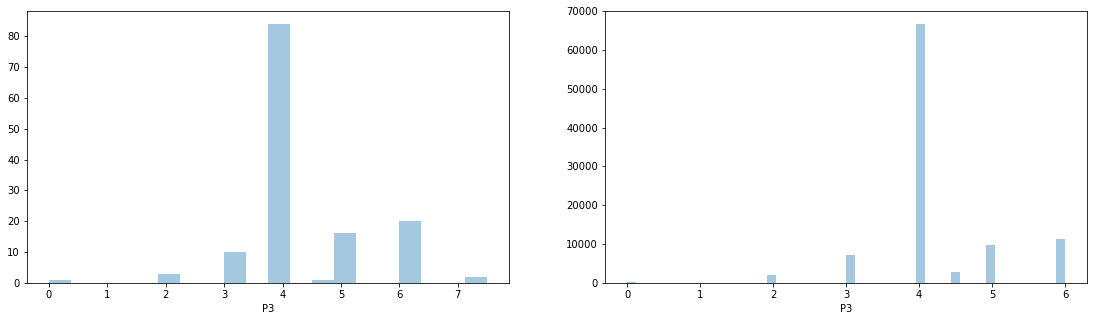

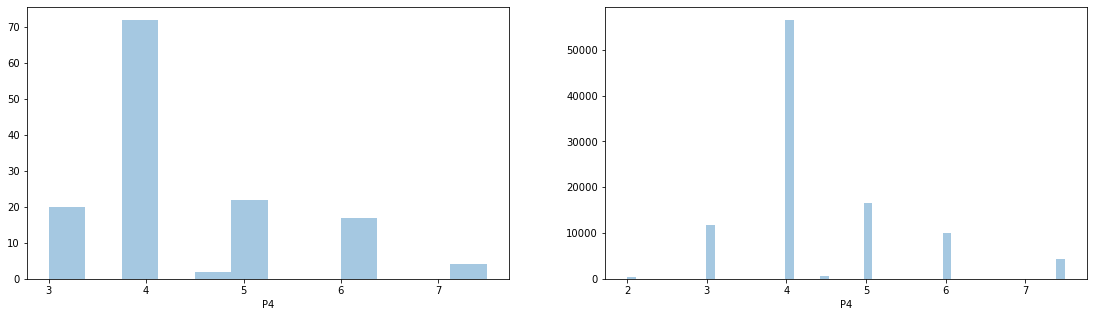

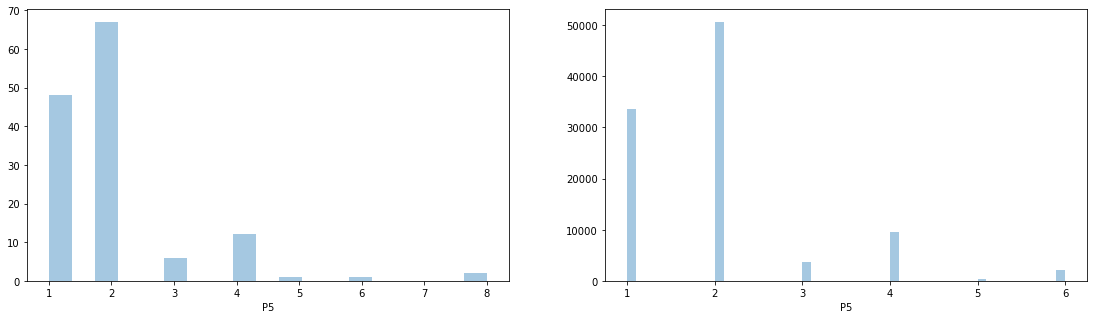

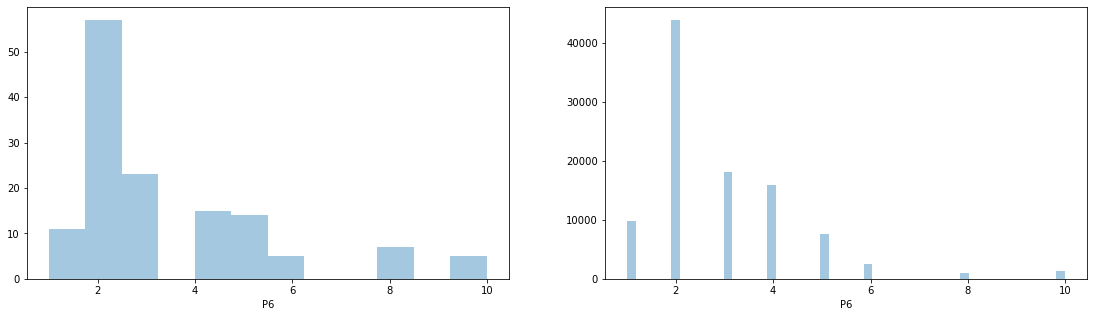

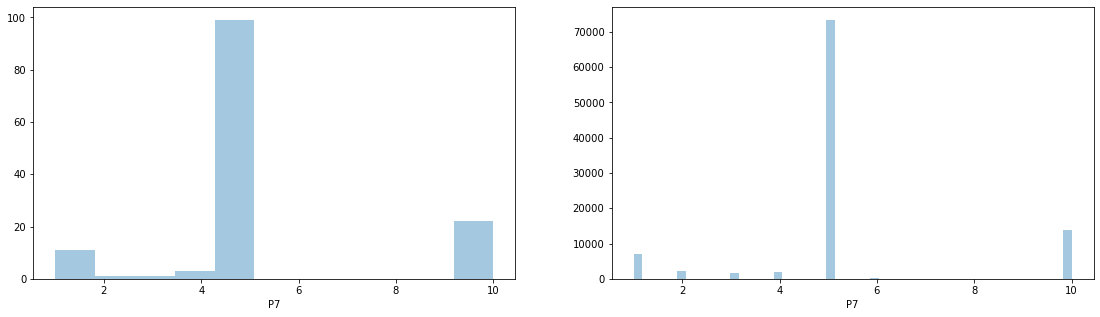

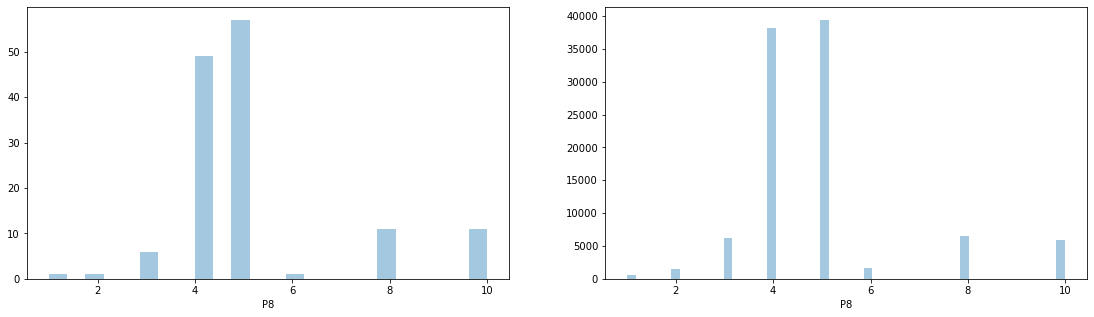

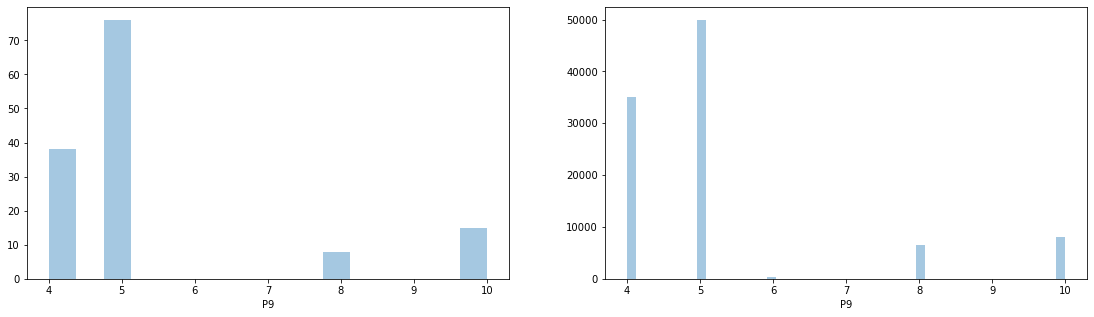

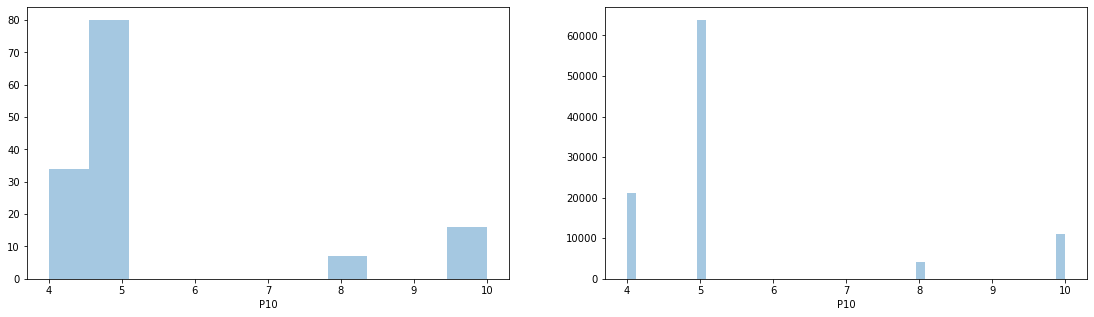

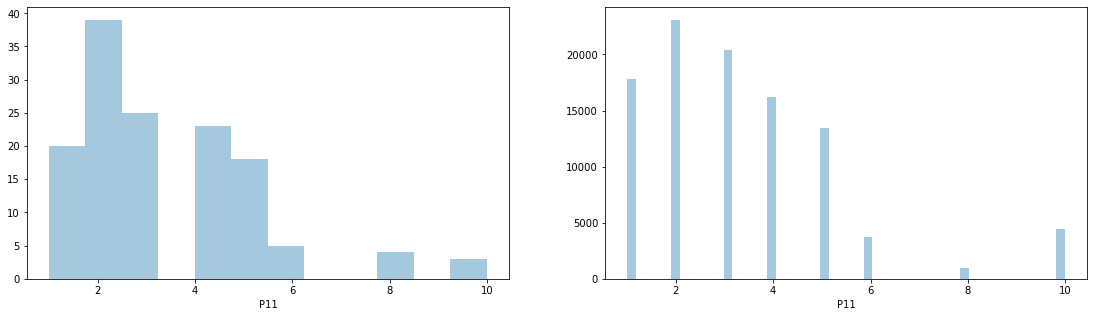

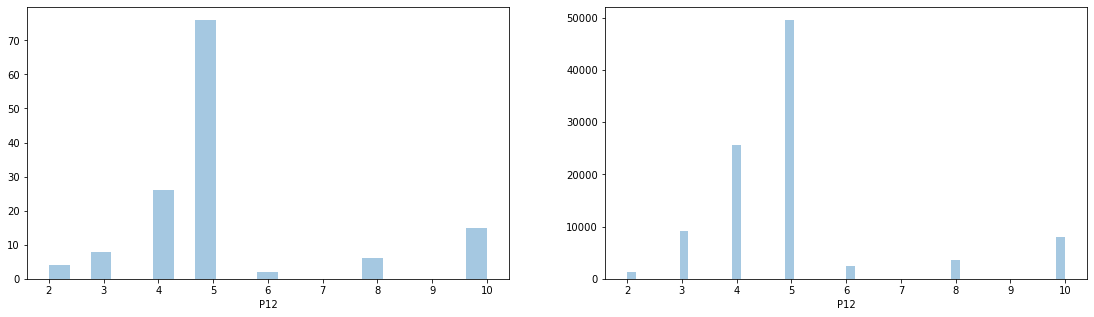

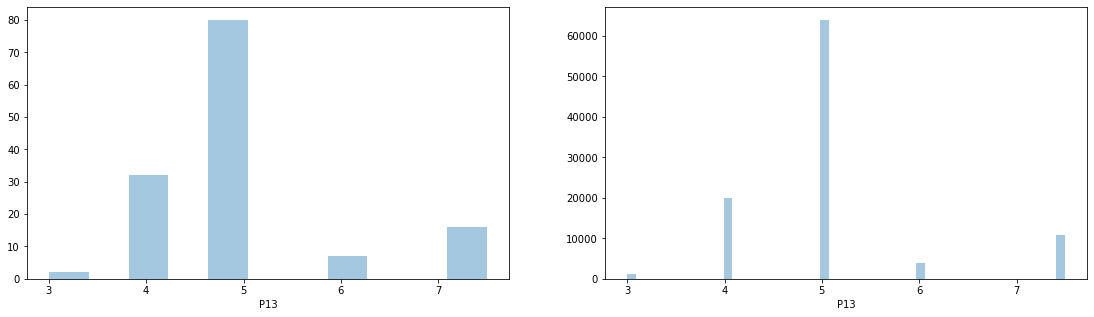

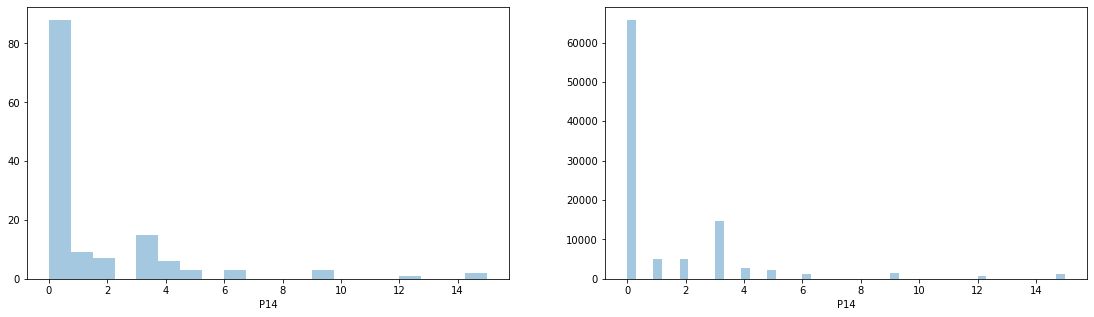

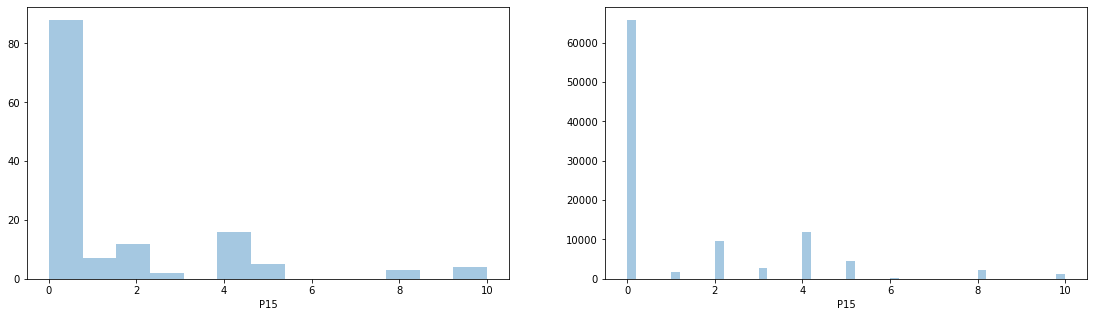

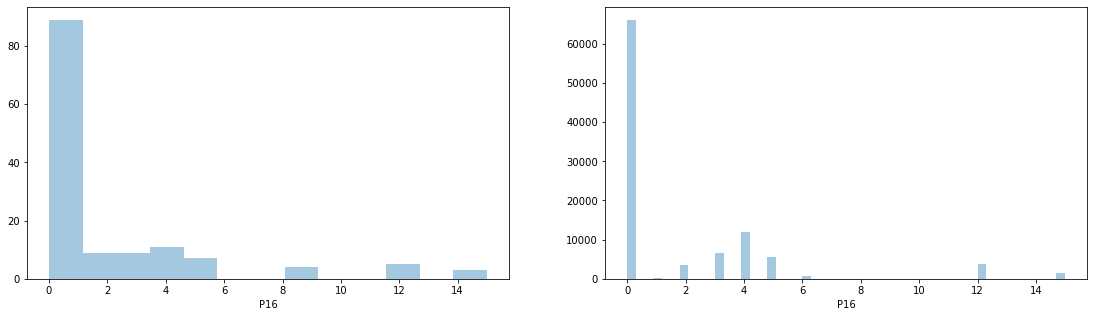

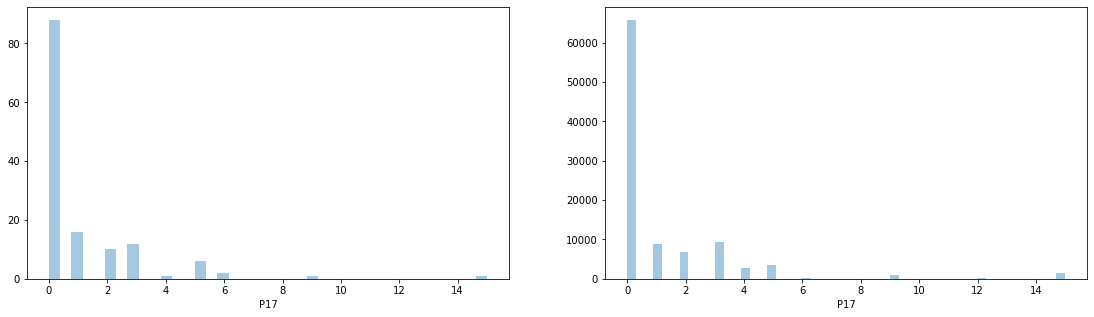

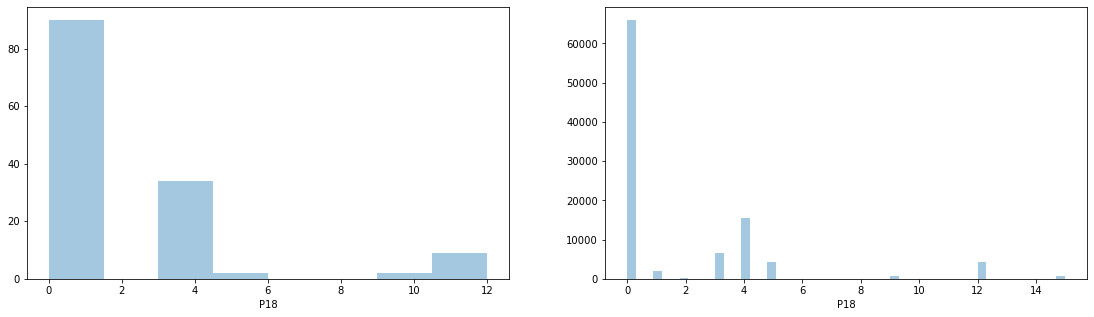

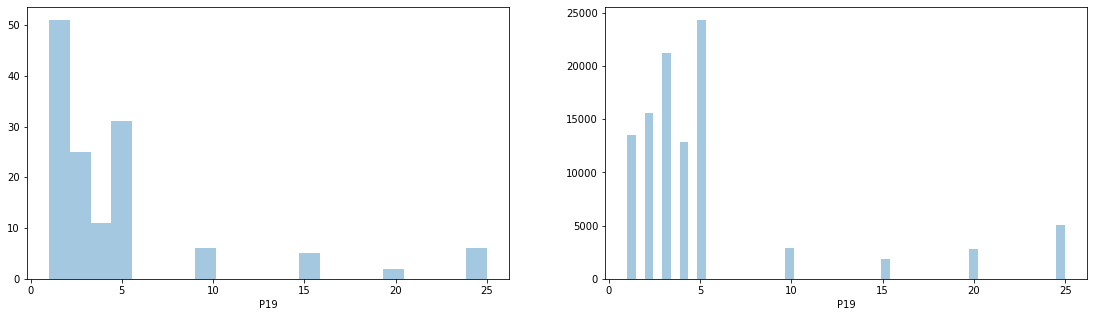

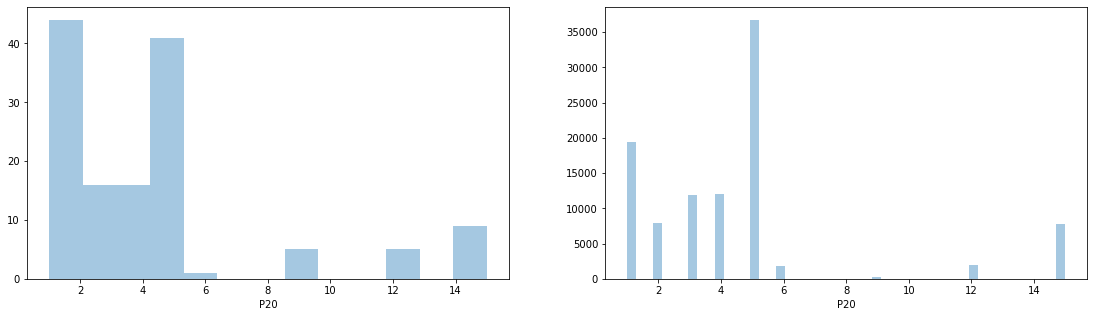

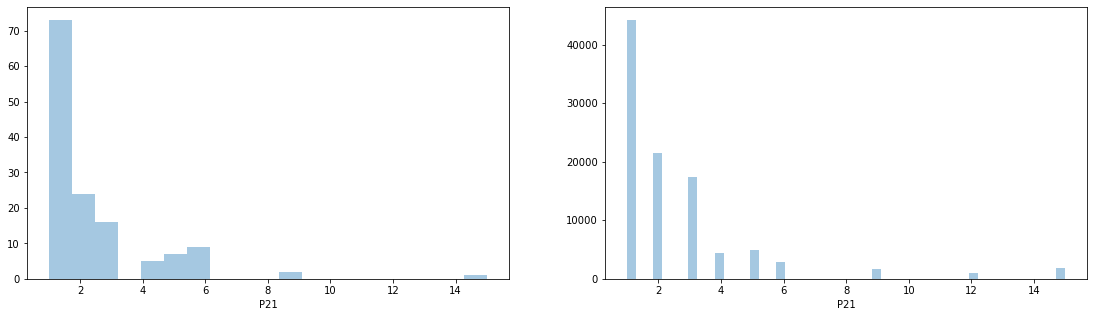

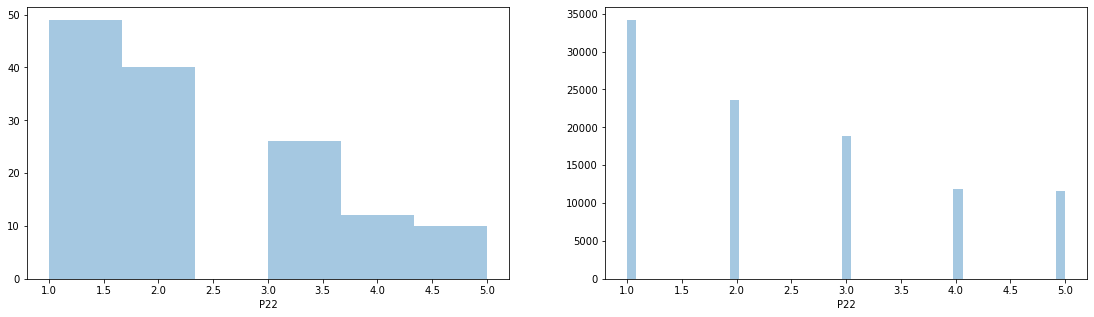

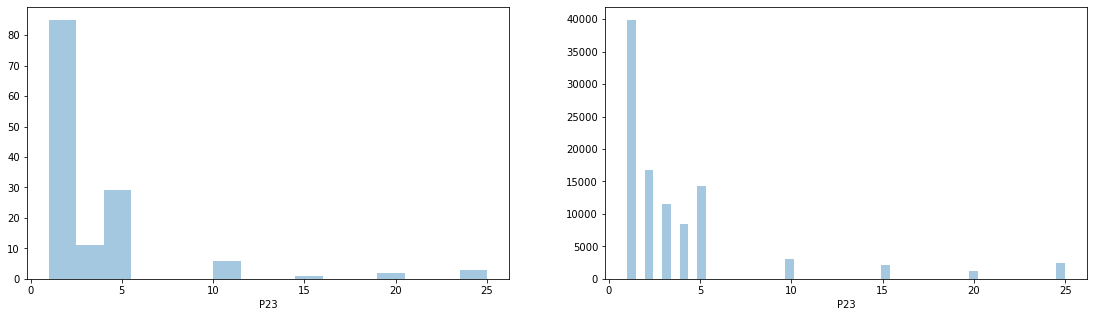

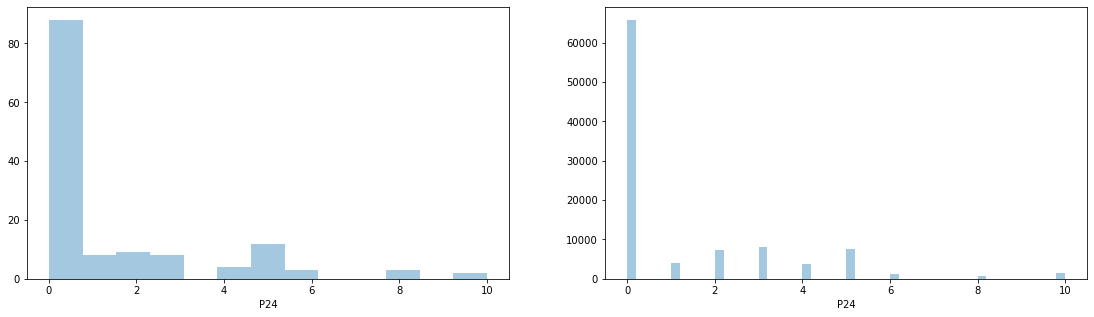

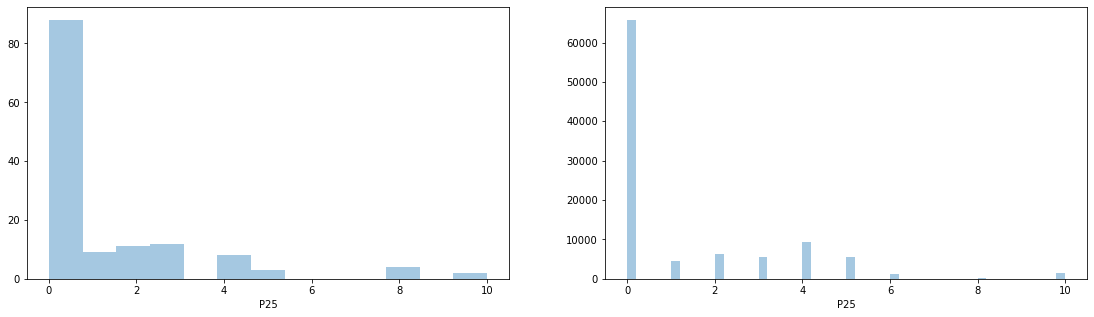

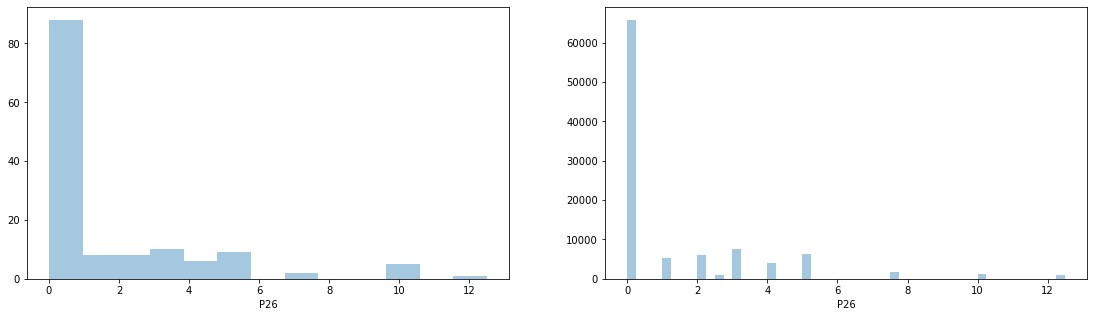

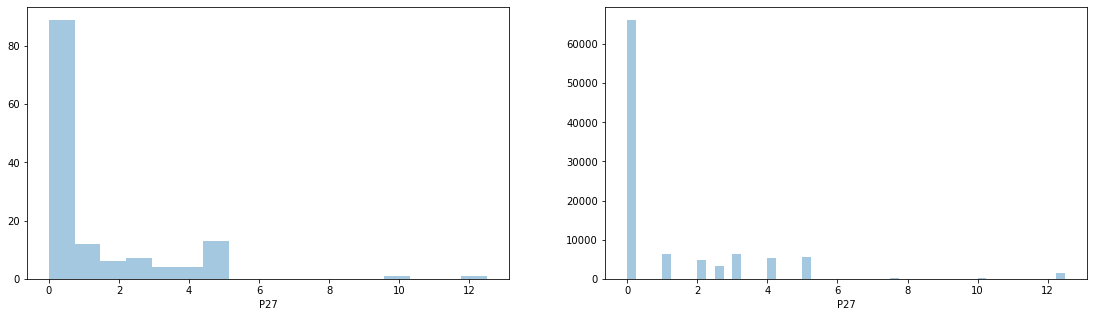

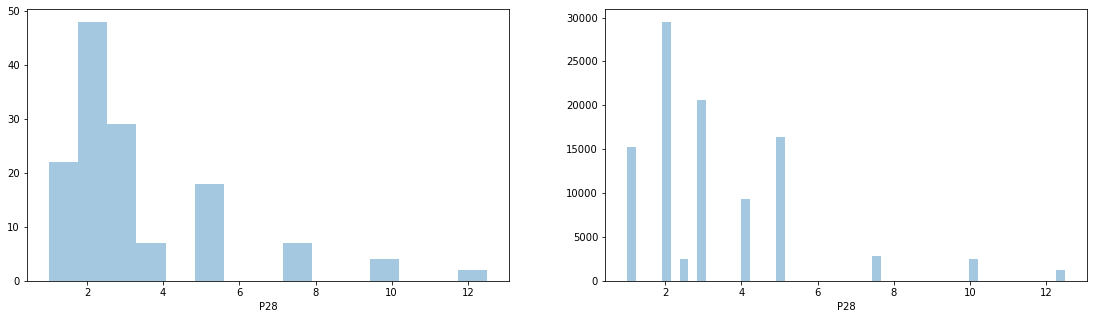

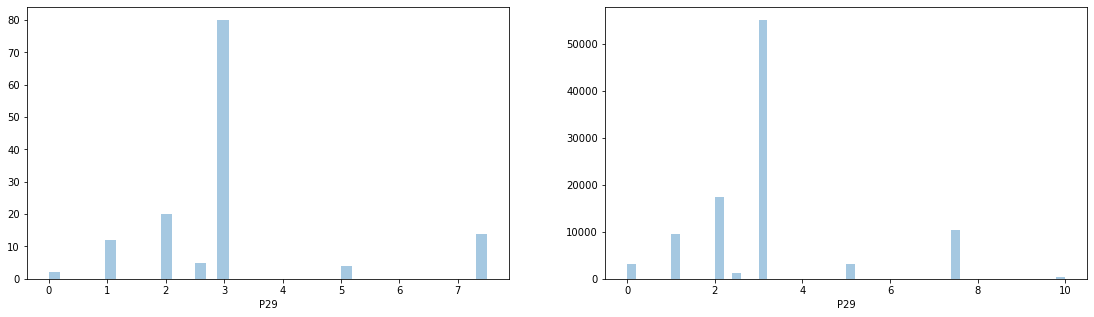

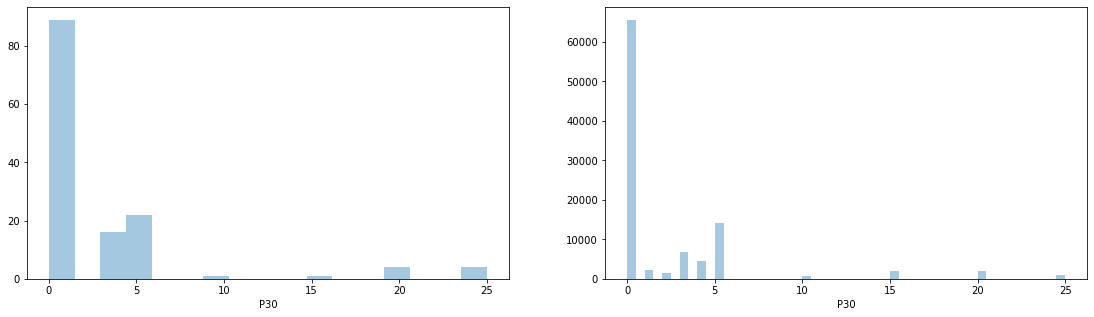

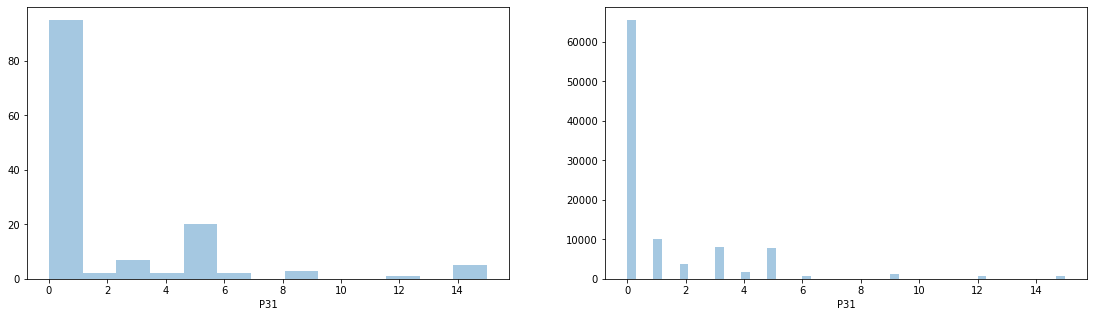

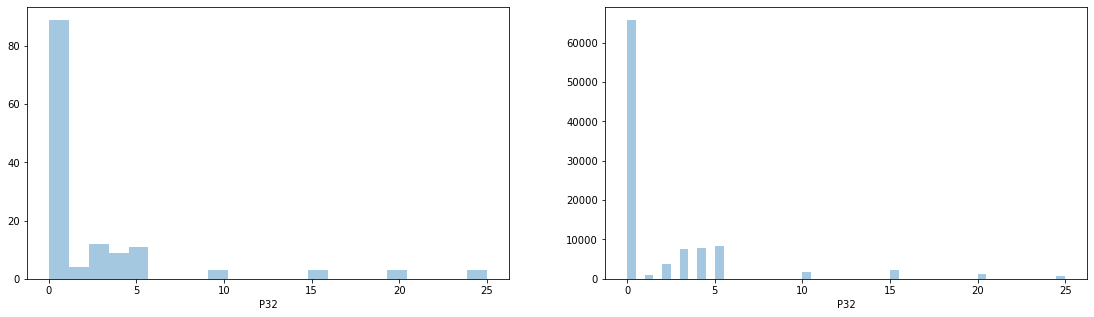

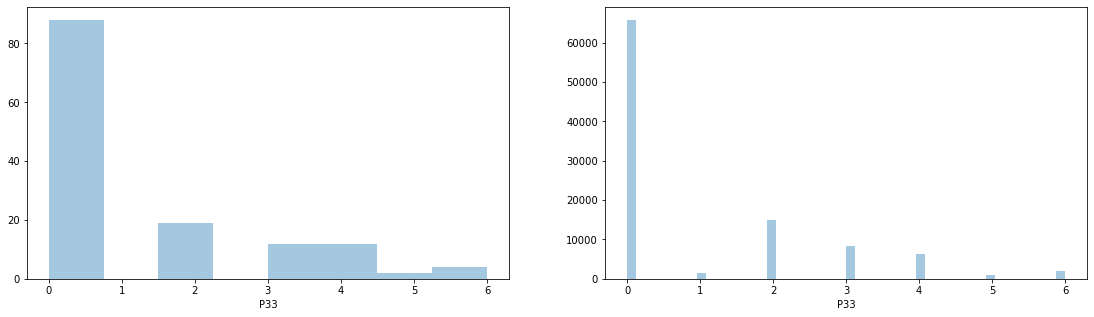

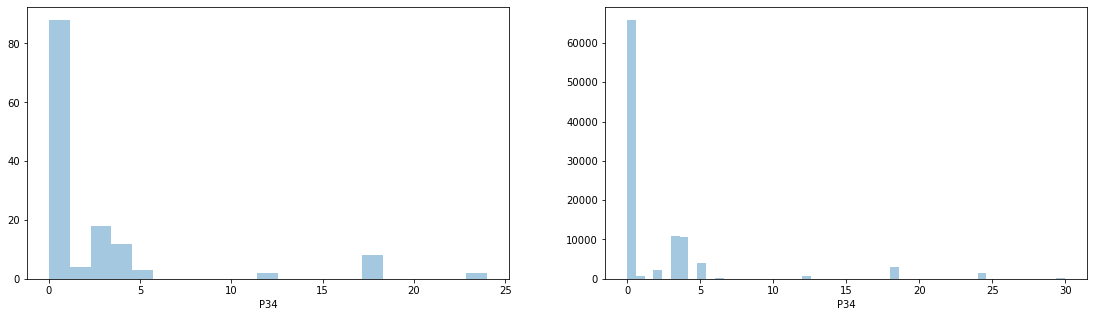

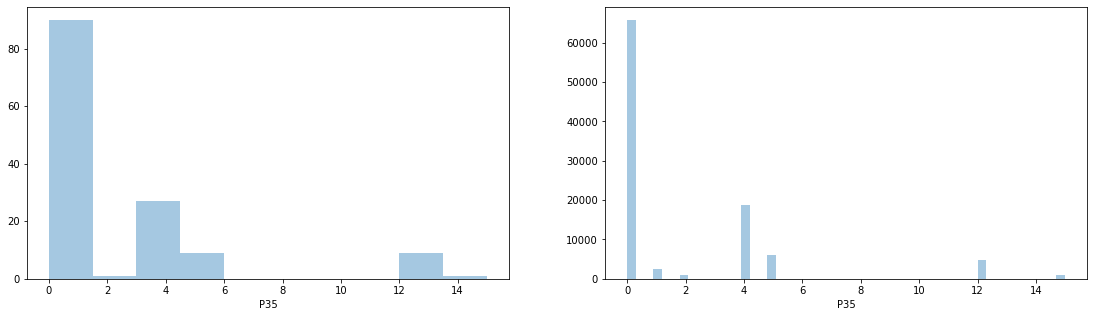

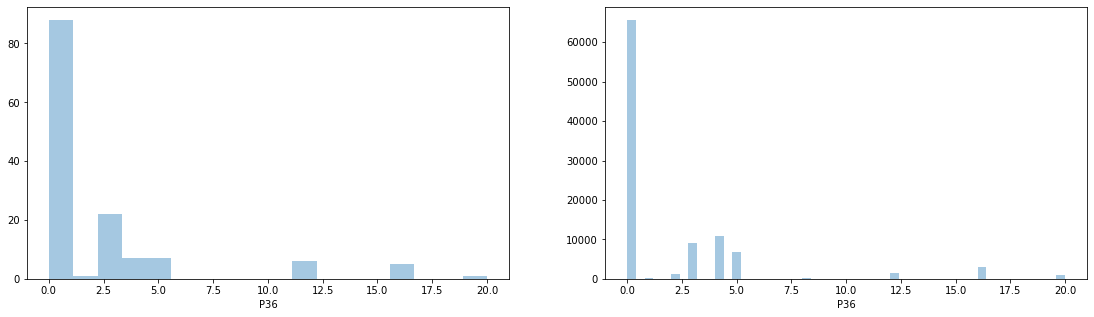

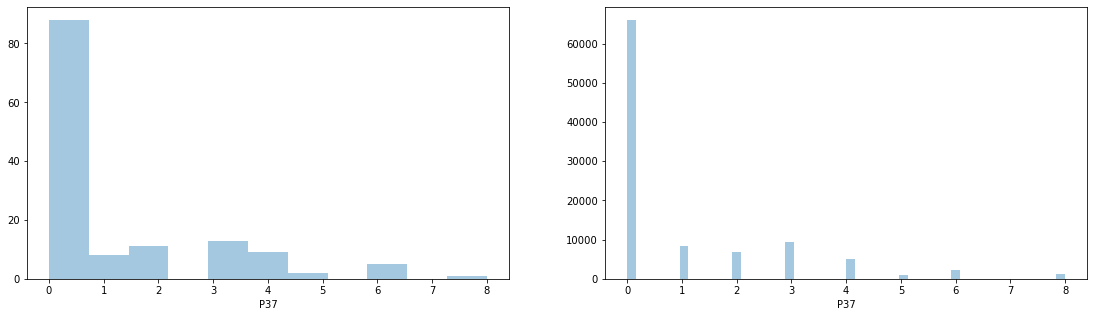

In [14]:
plt.rc('figure', max_open_warning = 0)
for i in range(1,38):
    fig, ax = plt.subplots(1,2, figsize=(19, 5))
    g1 = sns.distplot(df['P{}'.format(i)], ax=ax[0], kde=False);
    g2 = sns.distplot(test_df['P{}'.format(i)], ax=ax[1], kde=False);
    fig.show()

In [15]:
df.dtypes

City Group     object
Type           object
P1              int64
P2            float64
P3            float64
P4            float64
P5              int64
P6              int64
P7              int64
P8              int64
P9              int64
P10             int64
P11             int64
P12             int64
P13           float64
P14             int64
P15             int64
P16             int64
P17             int64
P18             int64
P19             int64
P20             int64
P21             int64
P22             int64
P23             int64
P24             int64
P25             int64
P26           float64
P27           float64
P28           float64
P29           float64
P30             int64
P31             int64
P32             int64
P33             int64
P34             int64
P35             int64
P36             int64
P37             int64
revenue       float64
Days Open     float64
dtype: object

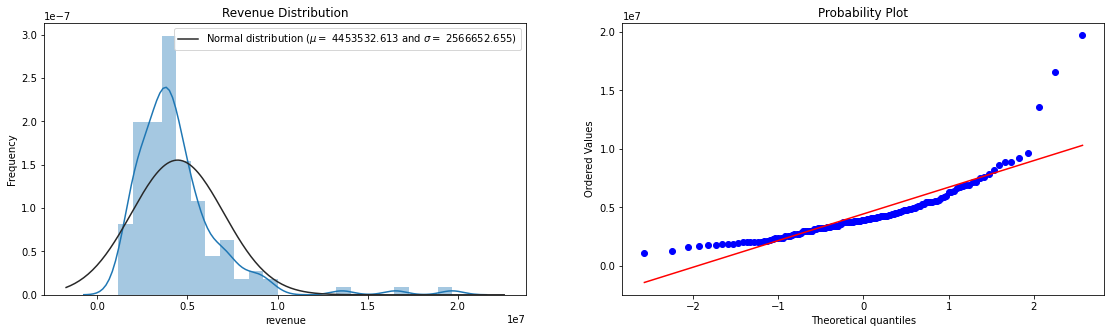

In [16]:
(mu, sigma) = norm.fit(df['revenue'])
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(19, 5))
ax1 = sns.distplot(df['revenue'] , fit=norm, ax=ax1)
ax1.legend([f'Normal distribution ($\mu=$ {mu:.3f} and $\sigma=$ {sigma:.3f})'], loc='best')
ax1.set_ylabel('Frequency')
ax1.set_title('Revenue Distribution')
ax2 = stats.probplot(df['revenue'], plot=plt)
f.show();

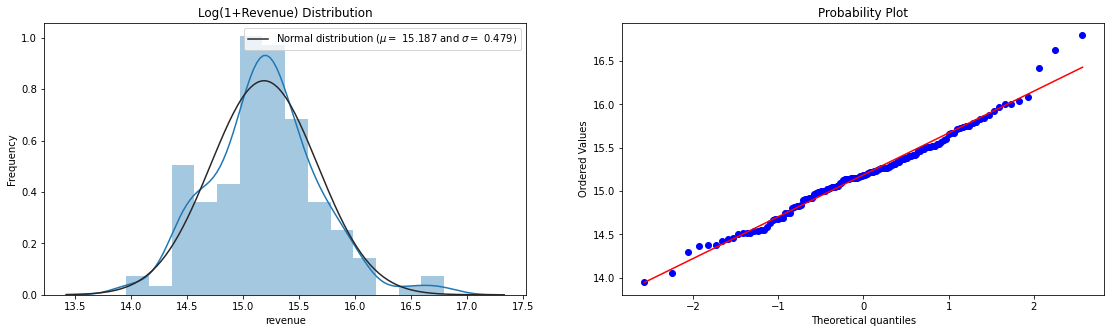

In [17]:
# Revenue is right skewed, taking the log will make it more normally distributed for the linear models
# Remember to use expm1 on predictions to transform back to dollar amount
(mu, sigma) = norm.fit(np.log1p(df['revenue']))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(19, 5))
ax1 = sns.distplot(np.log1p(df['revenue']) , fit=norm, ax=ax1)
ax1.legend([f'Normal distribution ($\mu=$ {mu:.3f} and $\sigma=$ {sigma:.3f})'], loc='best')
ax1.set_ylabel('Frequency')
ax1.set_title('Log(1+Revenue) Distribution')
ax2 = stats.probplot(np.log(df['revenue']), plot=plt)
f.show();

In [18]:
# cap revenue at 10,000,000 for outliers
# df.loc[df['revenue'] > 10000000, 'revenue'] = 10000000

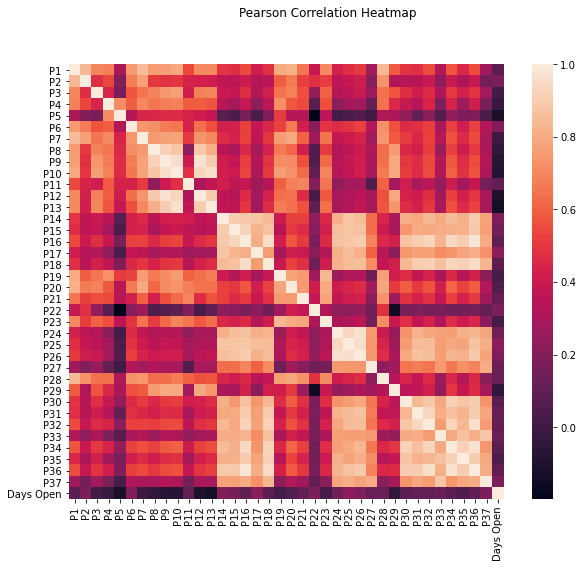

In [19]:
# Correlation between numeric features with revenue
plt.figure(figsize=(10, 8))
sns.heatmap(df.drop(['revenue','City Group','Type'], axis=1).corr(), square=True)
plt.suptitle('Pearson Correlation Heatmap')
plt.show();

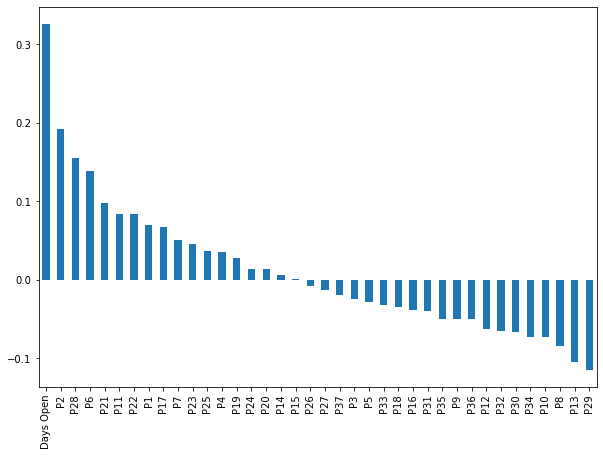

In [20]:
corr_with_revenue = df.drop(['City Group','Type'],axis=1).corr()['revenue'].sort_values(ascending=False)
plt.figure(figsize=(10,7))
corr_with_revenue.drop('revenue').plot.bar()
plt.show();

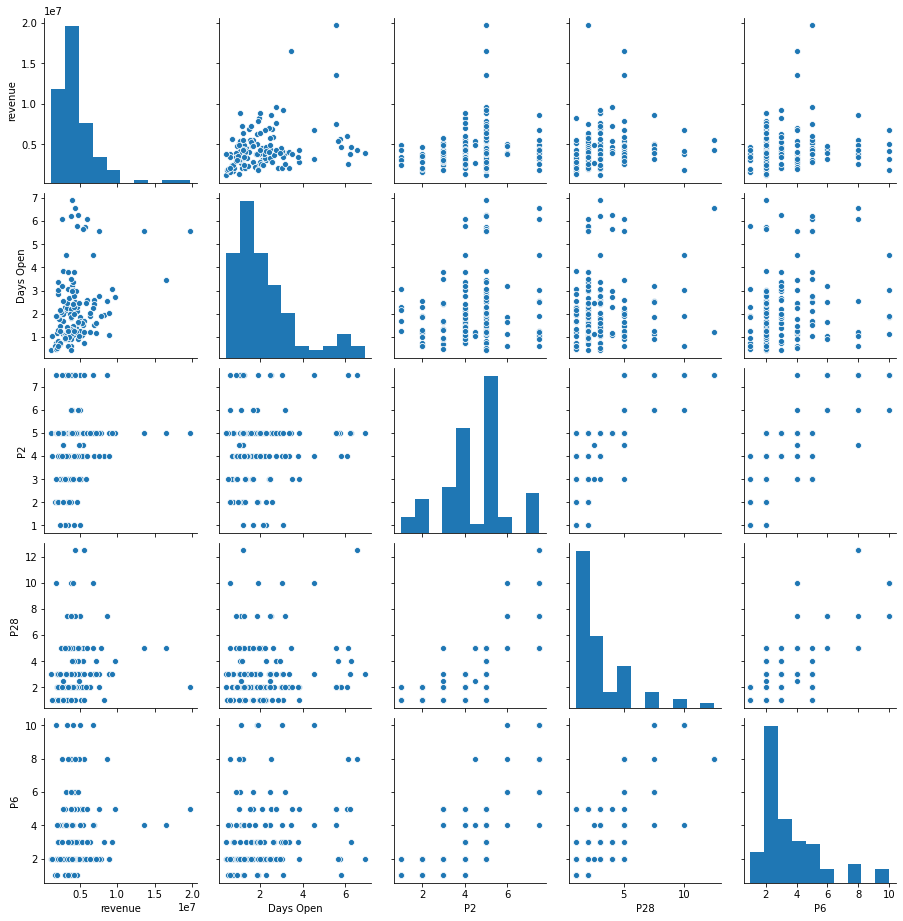

In [21]:
sns.pairplot(df[df.corr()['revenue'].sort_values(ascending=False).index[:5]])
plt.show();

# Feature Engineering

If the distribution of the data is left skewed, the skewness values will be negative. If the distribution of the data is right skewed, the skewness values will be positive.

In [22]:
# copy_df = df.copy()
# copy_test_df = test_df.copy()
# numeric_features = df.dtypes[df.dtypes != "object"].index
# skewed_features = df[numeric_features].apply(lambda x: skew(x))
# skewed_features = skewed_features[skewed_features > 0.5].index
# df[skewed_features] = np.log1p(df[skewed_features])
# test_df[skewed_features.drop('revenue')] = np.log1p(test_df[skewed_features.drop('revenue')])
# Above handles skewed features using log transformation
# Below uses multiple imputation for P1-P37, since they are actually categorical
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imp_train = IterativeImputer(max_iter=30, missing_values=0, sample_posterior=True, min_value=1, random_state=37)
imp_test = IterativeImputer(max_iter=30, missing_values=0, sample_posterior=True, min_value=1, random_state=23)

p_data = ['P'+str(i) for i in range(1,38)]
df[p_data] = np.round(imp_train.fit_transform(df[p_data]))
test_df[p_data] = np.round(imp_test.fit_transform(test_df[p_data]))

In [23]:
# drop_first=True for Dummy Encoding for object types, and drop_first=False for OHE
columnsToEncode = df.select_dtypes(include=[object]).columns
df = pd.get_dummies(df, columns=columnsToEncode, drop_first=False)
test_df = pd.get_dummies(test_df, columns=columnsToEncode, drop_first=False)

In [24]:
df['revenue'] = np.log1p(df['revenue'])
X, y = df.drop('revenue', axis=1), df['revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=118)

# Ridge and Lasso Regression

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

In [26]:
params_ridge = {
    'alpha' : [.01, .1, .5, .7, .9, .95, .99, 1, 5, 10, 20],
    'fit_intercept' : [True, False],
    'normalize' : [True,False],
    'solver' : ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}

ridge_model = Ridge()
ridge_regressor = GridSearchCV(ridge_model, params_ridge, scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1)
ridge_regressor.fit(X_train, y_train)
print(f'Optimal alpha: {ridge_regressor.best_params_["alpha"]:.2f}')
print(f'Optimal fit_intercept: {ridge_regressor.best_params_["fit_intercept"]}')
print(f'Optimal normalize: {ridge_regressor.best_params_["normalize"]}')
print(f'Optimal solver: {ridge_regressor.best_params_["solver"]}')
print(f'Best score: {ridge_regressor.best_score_}')

Optimal alpha: 1.00
Optimal fit_intercept: True
Optimal normalize: True
Optimal solver: saga
Best score: -0.4463902820636504


In [27]:
ridge_model = Ridge(alpha=ridge_regressor.best_params_["alpha"], fit_intercept=ridge_regressor.best_params_["fit_intercept"], 
                    normalize=ridge_regressor.best_params_["normalize"], solver=ridge_regressor.best_params_["solver"])
ridge_model.fit(X_train, y_train)
y_train_pred = ridge_model.predict(X_train)
y_pred = ridge_model.predict(X_test)
print('Train r2 score: ', r2_score(y_train_pred, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred))
train_rmse = np.sqrt(mean_squared_error(y_train_pred, y_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Train RMSE: {train_rmse:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')

Train r2 score:  -8.194131557202557
Test r2 score:  0.04071513024835127
Train RMSE: 0.4031
Test RMSE: 0.5413


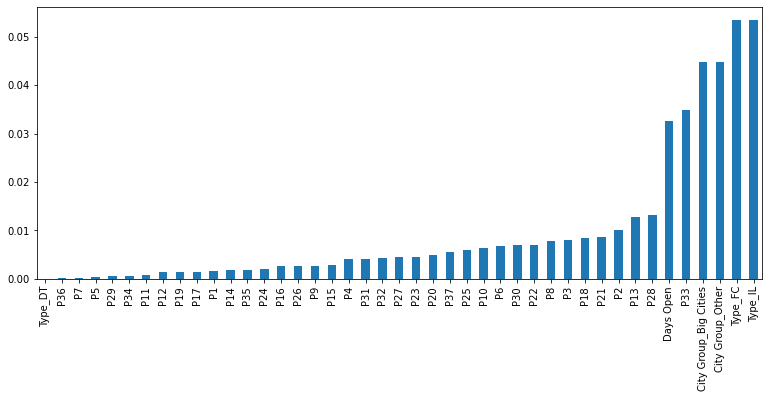

In [28]:
# Ridge Model Feature Importance
ridge_feature_coef = pd.Series(index = X_train.columns, data = np.abs(ridge_model.coef_))
ridge_feature_coef.sort_values().plot(kind = 'bar', figsize = (13,5));

In [29]:
params_lasso = {
    'alpha' : [.01, .1, .5, .7, .9, .95, .99, 1, 5, 10, 20],
    'fit_intercept' : [True, False],
    'normalize' : [True,False],
}

lasso_model = Lasso()
lasso_regressor = GridSearchCV(lasso_model, params_lasso, scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1)
lasso_regressor.fit(X_train, y_train)
print(f'Optimal alpha: {lasso_regressor.best_params_["alpha"]:.2f}')
print(f'Optimal fit_intercept: {lasso_regressor.best_params_["fit_intercept"]}')
print(f'Optimal normalize: {lasso_regressor.best_params_["normalize"]}')
print(f'Best score: {lasso_regressor.best_score_}')

Optimal alpha: 0.01
Optimal fit_intercept: True
Optimal normalize: True
Best score: -0.4530668566496237


In [30]:
lasso_model = Lasso(alpha=lasso_regressor.best_params_["alpha"], fit_intercept=lasso_regressor.best_params_["fit_intercept"], 
                    normalize=lasso_regressor.best_params_["normalize"])
lasso_model.fit(X_train, y_train)
y_train_pred = lasso_model.predict(X_train)
y_pred = lasso_model.predict(X_test)
print('Train r2 score: ', r2_score(y_train_pred, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred))
train_rmse = np.sqrt(mean_squared_error(y_train_pred, y_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Train RMSE: {train_rmse:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')

Train r2 score:  -327.6628679746241
Test r2 score:  0.02293335570713051
Train RMSE: 0.4508
Test RMSE: 0.5463


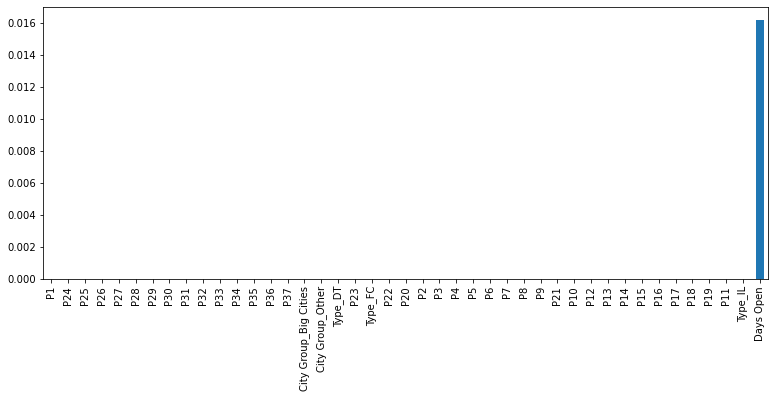

In [31]:
# Lasso Model Feature Importance
lasso_feature_coef = pd.Series(index = X_train.columns, data = np.abs(lasso_model.coef_))
lasso_feature_coef.sort_values().plot(kind = 'bar', figsize = (13,5));

# ElasticNet (combination of Ridge & Lasso)

In [32]:
from sklearn.linear_model import ElasticNetCV, ElasticNet

# Use ElasticNetCV to tune alpha automatically instead of redundantly using ElasticNet and GridSearchCV
el_model = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], eps=5e-2, cv=10, n_jobs=-1)         
el_model.fit(X_train, y_train)
print(f'Optimal alpha: {el_model.alpha_:.6f}')
print(f'Optimal l1_ratio: {el_model.l1_ratio_:.3f}')
print(f'Number of iterations {el_model.n_iter_}')

Optimal alpha: 0.622309
Optimal l1_ratio: 0.100
Number of iterations 34


In [33]:
y_train_pred = el_model.predict(X_train)
y_pred = el_model.predict(X_test)
print('Train r2 score: ', r2_score(y_train_pred, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred))
train_rmse = np.sqrt(mean_squared_error(y_train_pred, y_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Train RMSE: {train_rmse:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')

Train r2 score:  -9.795109289625826
Test r2 score:  0.05585927421195669
Train RMSE: 0.4128
Test RMSE: 0.5370


12 features with reduction of 72.09%


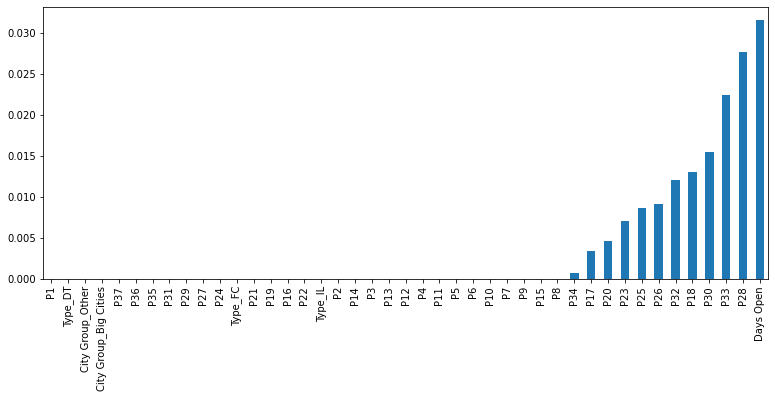

In [34]:
# ElasticNet Model Feature Importance
el_feature_coef = pd.Series(index = X_train.columns, data = np.abs(el_model.coef_))
n_features = (el_feature_coef>0).sum()
print(f'{n_features} features with reduction of {(1-n_features/len(el_feature_coef))*100:2.2f}%')
el_feature_coef.sort_values().plot(kind = 'bar', figsize = (13,5));

# K-Nearest Neighbors

In [35]:
from sklearn.neighbors import KNeighborsRegressor

params_knn = {
    'n_neighbors' : [3, 5, 7, 9, 11],
}

knn_model = KNeighborsRegressor()
knn_regressor = GridSearchCV(knn_model, params_knn, scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1)
knn_regressor.fit(X_train, y_train)
print(f'Optimal neighbors: {knn_regressor.best_params_["n_neighbors"]}')
print(f'Best score: {knn_regressor.best_score_}')

Optimal neighbors: 11
Best score: -0.43011660772832583


In [36]:
knn_model = KNeighborsRegressor(n_neighbors=knn_regressor.best_params_["n_neighbors"])
knn_model.fit(X_train, y_train)
y_train_pred = knn_model.predict(X_train)
y_pred = knn_model.predict(X_test)
print('Train r2 score: ', r2_score(y_train_pred, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred))
train_rmse = np.sqrt(mean_squared_error(y_train_pred, y_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Train RMSE: {train_rmse:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')

Train r2 score:  -7.188173431615837
Test r2 score:  0.1434305705894996
Train RMSE: 0.4071
Test RMSE: 0.5115


# Random Forest

In [37]:
from sklearn.ensemble import RandomForestRegressor

params_rf = {
    'max_depth': [10, 30, 35, 50, 65, 75, 100],
    'max_features': [.3, .4, .5, .6],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [30, 50, 100, 200]
}

rf = RandomForestRegressor()
rf_regressor = GridSearchCV(rf, params_rf, scoring='neg_root_mean_squared_error', cv = 10, n_jobs = -1)
rf_regressor.fit(X_train, y_train)
print(f'Optimal depth: {rf_regressor.best_params_["max_depth"]}')
print(f'Optimal max_features: {rf_regressor.best_params_["max_features"]}')
print(f'Optimal min_sample_leaf: {rf_regressor.best_params_["min_samples_leaf"]}')
print(f'Optimal min_samples_split: {rf_regressor.best_params_["min_samples_split"]}')
print(f'Optimal n_estimators: {rf_regressor.best_params_["n_estimators"]}')
print(f'Best score: {rf_regressor.best_score_}')

Optimal depth: 10
Optimal max_features: 0.3
Optimal min_sample_leaf: 4
Optimal min_samples_split: 8
Optimal n_estimators: 50
Best score: -0.4000337080466469


In [38]:
rf_model = RandomForestRegressor(max_depth=rf_regressor.best_params_["max_depth"], 
                                 max_features=rf_regressor.best_params_["max_features"], 
                                 min_samples_leaf=rf_regressor.best_params_["min_samples_leaf"], 
                                 min_samples_split=rf_regressor.best_params_["min_samples_split"], 
                                 n_estimators=rf_regressor.best_params_["n_estimators"], 
                                 n_jobs=-1, oob_score=True)
rf_model.fit(X_train, y_train)
y_train_pred = rf_model.predict(X_train)
y_pred = rf_model.predict(X_test)
print('Train r2 score: ', r2_score(y_train_pred, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred))
train_rmse = np.sqrt(mean_squared_error(y_train_pred, y_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Train RMSE: {train_rmse:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')

Train r2 score:  -0.6757065673586051
Test r2 score:  0.19980759117131874
Train RMSE: 0.2795
Test RMSE: 0.4944


42 features with reduction of 2.33%


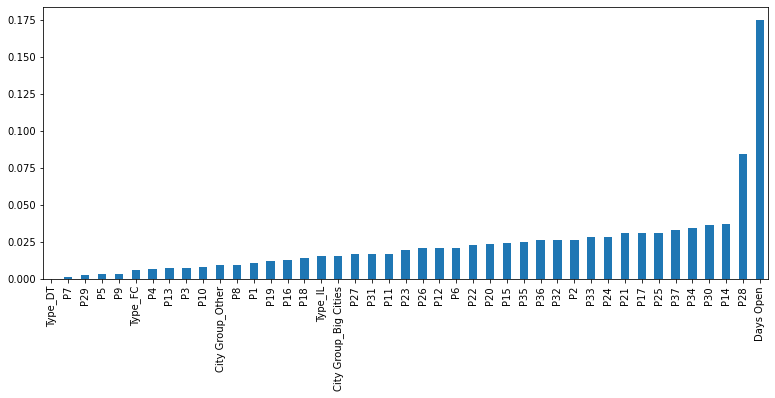

In [39]:
# Random Forest Model Feature Importance
rf_feature_importance = pd.Series(index = X_train.columns, data = np.abs(rf_model.feature_importances_))
n_features = (rf_feature_importance>0).sum()
print(f'{n_features} features with reduction of {(1-n_features/len(rf_feature_importance))*100:2.2f}%')
rf_feature_importance.sort_values().plot(kind = 'bar', figsize = (13,5));

# Light GBM

In [40]:
import lightgbm as lgbm

params_lgbm = {
    'learning_rate': [.01, .1, .5, .7, .9, .95, .99, 1],
    'boosting': ['gbdt'],
    'metric': ['l1'],
    'feature_fraction': [.3, .4, .5, 1],
    'num_leaves': [20],
    'min_data': [10],
    'max_depth': [10],
    'n_estimators': [10, 30, 50, 100]
}

lgb = lgbm.LGBMRegressor()
lgb_regressor = GridSearchCV(lgb, params_lgbm, scoring='neg_root_mean_squared_error', cv = 10, n_jobs = -1)
lgb_regressor.fit(X_train, y_train)
print(f'Optimal lr: {lgb_regressor.best_params_["learning_rate"]}')
print(f'Optimal feature_fraction: {lgb_regressor.best_params_["feature_fraction"]}')
print(f'Optimal n_estimators: {lgb_regressor.best_params_["n_estimators"]}')
print(f'Best score: {lgb_regressor.best_score_}')

Optimal lr: 0.1
Optimal feature_fraction: 0.4
Optimal n_estimators: 50
Best score: -0.38394173043287


In [41]:
lgb_model = lgbm.LGBMRegressor(learning_rate=lgb_regressor.best_params_["learning_rate"], boosting='gbdt', 
                               metric='l1', feature_fraction=lgb_regressor.best_params_["feature_fraction"], 
                               num_leaves=20, min_data=10, max_depth=10, 
                               n_estimators=lgb_regressor.best_params_["n_estimators"], n_jobs=-1)
lgb_model.fit(X_train, y_train)
y_train_pred = lgb_model.predict(X_train)
y_pred = lgb_model.predict(X_test)
print('Train r2 score: ', r2_score(y_train_pred, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred))
train_rmse = np.sqrt(mean_squared_error(y_train_pred, y_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Train RMSE: {train_rmse:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')

Train r2 score:  0.8402215166975928
Test r2 score:  0.1972437367117208
Train RMSE: 0.1425
Test RMSE: 0.4952


41 features with reduction of 4.65%


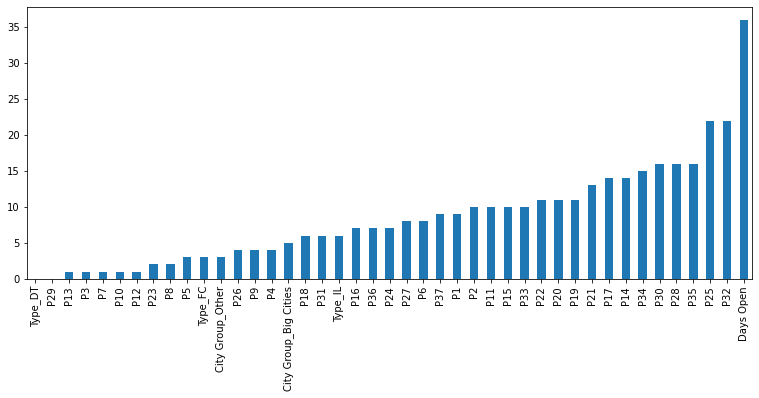

In [42]:
# LightGBM Feature Importance
lgb_feature_importance = pd.Series(index = X_train.columns, data = np.abs(lgb_model.feature_importances_))
n_features = (lgb_feature_importance>0).sum()
print(f'{n_features} features with reduction of {(1-n_features/len(lgb_feature_importance))*100:2.2f}%')
lgb_feature_importance.sort_values().plot(kind = 'bar', figsize = (13,5));

# XGBoost

In [43]:
params_xgb = {
    'learning_rate': [.1, .5, .7, .9, .95, .99, 1],
    'colsample_bytree': [.3, .4, .5, .6],
    'max_depth': [4],
    'alpha': [3],
    'subsample': [.5],
    'n_estimators': [30, 70, 100, 200]
}

xgb_model = XGBRegressor()
xgb_regressor = GridSearchCV(xgb_model, params_xgb, scoring='neg_root_mean_squared_error', cv = 10, n_jobs = -1)
xgb_regressor.fit(X_train, y_train)
print(f'Optimal lr: {xgb_regressor.best_params_["learning_rate"]}')
print(f'Optimal colsample_bytree: {xgb_regressor.best_params_["colsample_bytree"]}')
print(f'Optimal n_estimators: {xgb_regressor.best_params_["n_estimators"]}')
print(f'Best score: {xgb_regressor.best_score_}')

Optimal lr: 0.95
Optimal colsample_bytree: 0.5
Optimal n_estimators: 100
Best score: -0.3992164151795667


In [44]:
xgb_model = XGBRegressor(learning_rate=xgb_regressor.best_params_["learning_rate"], 
                         colsample_bytree=xgb_regressor.best_params_["colsample_bytree"], 
                         max_depth=4, alpha=3, subsample=.5, 
                         n_estimators=xgb_regressor.best_params_["n_estimators"], n_jobs=-1)
xgb_model.fit(X_train, y_train)
y_train_pred = xgb_model.predict(X_train)
y_pred = xgb_model.predict(X_test)
print('Train r2 score: ', r2_score(y_train_pred, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred))
train_rmse = np.sqrt(mean_squared_error(y_train_pred, y_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Train RMSE: {train_rmse:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')

Train r2 score:  0.5795086544898738
Test r2 score:  0.32589181766269526
Train RMSE: 0.2309
Test RMSE: 0.4538


In [45]:
# XGB with early stopping
xgb_model.fit(X_train, y_train, early_stopping_rounds=4,
             eval_set=[(X_test, y_test)], verbose=False)
y_train_pred = xgb_model.predict(X_train)
y_pred = xgb_model.predict(X_test)
print('Train r2 score: ', r2_score(y_train_pred, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred))
train_rmse = np.sqrt(mean_squared_error(y_train_pred, y_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Train RMSE: {train_rmse:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')

Train r2 score:  -0.15853608490123916
Test r2 score:  0.3050460256750407
Train RMSE: 0.3131
Test RMSE: 0.4607


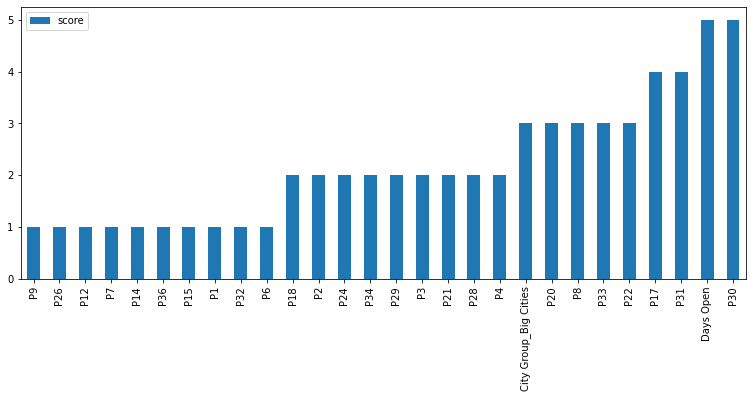

In [46]:
# XGB Feature Importance, relevant features can be selected based on its score
feature_important = xgb_model.get_booster().get_fscore()
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=['score']).sort_values(by = 'score', ascending=True)
data.plot(kind='bar', figsize = (13,5))
plt.show()

# Regressor Ensembling

In [47]:
rf_model_en = RandomForestRegressor(max_depth=200, max_features=0.4, min_samples_leaf=3, 
                                 min_samples_split=6, n_estimators=30, n_jobs=-1, oob_score=True)
rf_model_en.fit(X_train, y_train)
y_train_pred = rf_model_en.predict(X_train)
y_pred = rf_model_en.predict(X_test)
print('Train r2 score: ', r2_score(y_train_pred, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred))
train_rmse = np.sqrt(mean_squared_error(y_train_pred, y_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Train RMSE: {train_rmse:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')

Train r2 score:  0.1950478436934554
Test r2 score:  0.24894052959983848
Train RMSE: 0.2357
Test RMSE: 0.4790


ridge -0.355 0.087
lasso -0.349 0.096
rf_en -0.346 0.080
stacking -0.356 0.081


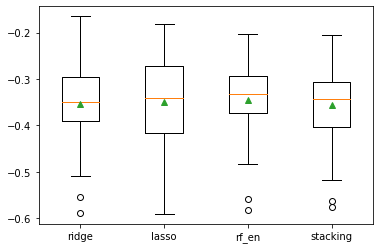

In [48]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor
from matplotlib import pyplot

# get a stacking ensemble of models
def get_stacking():
    # define the base models
    base_models = list()
    base_models.append(('ridge', ridge_model))
    base_models.append(('lasso', lasso_model))
    base_models.append(('rf', rf_model_en))
    # define meta learner model
    learner = LinearRegression()
    # define the stacking ensemble
    model = StackingRegressor(estimators=base_models, final_estimator=learner, cv=10)
    return model
 
# get a list of models to evaluate
def get_models():
    models = dict()
    models['ridge'] = ridge_model
    models['lasso'] = lasso_model
    models['rf_en'] = rf_model_en
    models['stacking'] = get_stacking()
    return models
 
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=19)
    scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train, y_train)
    results.append(scores)
    names.append(name)
    print(f'{name} {mean(scores):.3f} {std(scores):.3f}')
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [49]:
# define the base models
base_models = list()
base_models.append(('ridge', ridge_model))
base_models.append(('lasso', lasso_model))
base_models.append(('rf', rf_model_en))
# define meta learner model
learner = LinearRegression()
# define the stacking ensemble
stack1 = StackingRegressor(estimators=base_models, final_estimator=learner, cv=10)
# fit the model on all available data
stack1.fit(X, y)

StackingRegressor(cv=10,
                  estimators=[('ridge',
                               Ridge(alpha=1, normalize=True, solver='saga')),
                              ('lasso', Lasso(alpha=0.01, normalize=True)),
                              ('rf',
                               RandomForestRegressor(max_depth=200,
                                                     max_features=0.4,
                                                     min_samples_leaf=3,
                                                     min_samples_split=6,
                                                     n_estimators=30, n_jobs=-1,
                                                     oob_score=True))],
                  final_estimator=LinearRegression())

In [50]:
# define the base models
base_model = list()
base_model.append(('rf1', rf_model))
base_model.append(('rf2', rf_model_en))
base_model.append(('rf3', RandomForestRegressor(max_depth=8, max_features=0.1, min_samples_leaf=3, 
                                                min_samples_split=2, n_estimators=250, n_jobs=-1, oob_score=False)))
# define meta learner model
learner = LinearRegression()
# define the stacking ensemble
stack2 = StackingRegressor(estimators=base_model, final_estimator=learner, cv=10)
# fit the model on all available data
stack2.fit(X, y)

StackingRegressor(cv=10,
                  estimators=[('rf1',
                               RandomForestRegressor(max_depth=10,
                                                     max_features=0.3,
                                                     min_samples_leaf=4,
                                                     min_samples_split=8,
                                                     n_estimators=50, n_jobs=-1,
                                                     oob_score=True)),
                              ('rf2',
                               RandomForestRegressor(max_depth=200,
                                                     max_features=0.4,
                                                     min_samples_leaf=3,
                                                     min_samples_split=6,
                                                     n_estimators=30, n_jobs=-1,
                                                     oob_score=True)),
                        

# Submissions

In [51]:
submission = pd.DataFrame(columns=['Id','Prediction'])
submission['Id'] = test_df['Id']

ridge_pred = ridge_model.predict(test_df.drop('Id', axis=1))
submission['Prediction'] = np.expm1(ridge_pred)
submission.to_csv('submission_ridge.csv',index=False)

lasso_pred = lasso_model.predict(test_df.drop('Id', axis=1))
submission['Prediction'] = np.expm1(lasso_pred)
submission.to_csv('submission_lasso.csv',index=False)

elastic_pred = el_model.predict(test_df.drop('Id', axis=1))
submission['Prediction'] = np.expm1(elastic_pred)
submission.to_csv('submission_elastic.csv',index=False)

knn_pred = knn_model.predict(test_df.drop('Id', axis=1))
submission['Prediction'] = np.expm1(knn_pred)
submission.to_csv('submission_knn.csv',index=False)

rf_pred = rf_model.predict(test_df.drop('Id', axis=1))
submission['Prediction'] = np.expm1(rf_pred)
submission.to_csv('submission_rf.csv',index=False)

lgb_pred = lgb_model.predict(test_df.drop('Id', axis=1))
submission['Prediction'] = np.expm1(lgb_pred)
submission.to_csv('submission_lgb.csv',index=False)

xgb_pred = xgb_model.predict(test_df.drop('Id', axis=1))
submission['Prediction'] = np.expm1(xgb_pred)
submission.to_csv('submission_xgb.csv',index=False)

stack_pred1 = stack1.predict(test_df.drop('Id', axis=1))
submission['Prediction'] = np.expm1(stack_pred1)
submission.to_csv('submission_stack1.csv',index=False)

stack_pred2 = stack2.predict(test_df.drop('Id', axis=1))
submission['Prediction'] = np.expm1(stack_pred2)
submission.to_csv('submission_stack2.csv',index=False)